In [1]:
import numpy as np 
import tensorflow as tf 
import tensorflow_probability as tfp
from tensorflow import keras

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# MNIST dataset

In [4]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype(np.float32) / 255
x_test = x_test.astype(np.float32) / 255

11493376/11490434 [==============================] - 0s 0us/step


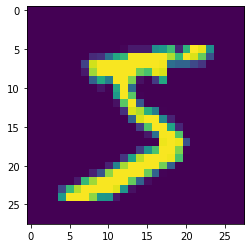

In [5]:
plt.imshow(x_train[0])

# Variational Autoencoder

In [44]:
# Some general information on the data
input_shape = (28, 28, 1)
encoded_size = 40

In [45]:
# This is the prior on the latent space (which we assumed to be 40-dimensional)
prior = tfp.distributions.Independent(
    tfp.distributions.Normal(
        loc=tf.zeros(encoded_size),
        scale=1.0,
    ),
    reinterpreted_batch_ndims=1,
)

In [46]:
# Explore the prior
print(prior)
prior.sample(1)

tfp.distributions.Independent("IndependentNormal", batch_shape=[], event_shape=[40], dtype=float32)


<tf.Tensor: shape=(1, 40), dtype=float32, numpy=
array([[ 1.4711041 , -1.6341562 ,  1.105325  , -0.12961638, -0.03893477,
        -1.008239  , -1.7084885 , -0.27491644, -0.34605995, -0.29213294,
         0.39420554, -0.5741025 ,  1.1279949 , -0.94496006,  0.63413346,
        -0.36834875, -0.18733507, -0.91080594,  0.03373637, -0.77165717,
        -1.5719982 , -0.3856489 ,  0.7380592 , -0.9795575 ,  0.07329593,
        -0.6060336 , -0.13269772, -0.44528887, -0.92689294,  0.7305634 ,
         0.40073776, -0.5826444 , -1.4229927 , -0.9884907 , -0.5581511 ,
        -0.05062386, -1.1207061 ,  0.0306418 ,  0.61606306, -0.79370284]],
      dtype=float32)>

In [47]:
# Define the encoder and decoder network (note that the last two
# layers are probabilistic and have to use the reparametrization trick,
# which is automatically done by tfp)
encoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=input_shape),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(300, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(
        tfp.layers.MultivariateNormalTriL.params_size(encoded_size),
        activation=None,
    ),
    tfp.layers.MultivariateNormalTriL(
        encoded_size,
        activity_regularizer=tfp.layers.KLDivergenceRegularizer(prior),
    )
])

In [55]:
decoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=[encoded_size]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(784, activation="relu"),
    tfp.layers.IndependentBernoulli(
        input_shape,
        tfp.distributions.Bernoulli.logits
    )
])

In [56]:
vae = tf.keras.Model(inputs=encoder.inputs, outputs=decoder(encoder.outputs[0]))

In [57]:
# Train the model (with variational inference)
neg_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)

vae.compile(optimizer=tf.optimizers.Adam(1.0e-3), loss=neg_log_likelihood)


In [58]:
import tensorflow_datasets as tfds

datasets, datasets_info = tfds.load(name='mnist',
                                    with_info=True,
                                    as_supervised=False)

def _preprocess(sample):
  image = tf.cast(sample['image'], tf.float32) / 255.  # Scale to unit interval.
  image = image < tf.random.uniform(tf.shape(image))   # Randomly binarize.
  return image, image

train_dataset = (datasets['train']
                 .map(_preprocess)
                 .batch(100)
                 .prefetch(tf.data.experimental.AUTOTUNE)
                 .shuffle(int(10e3)))
eval_dataset = (datasets['test']
                .map(_preprocess)
                .batch(100)
                .prefetch(tf.data.experimental.AUTOTUNE))

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype(np.float32) / 255.
x_test = x_test.astype(np.float32) / 255.


In [59]:
datasets_info.features["image"].shape

(28, 28, 1)

In [74]:
with tf.device('/device:GPU:0'):
    _ = vae.fit(train_dataset,
            epochs=100,
            validation_data=eval_dataset)

Epoch 1/100
600/600 [==============================] - 6s 6ms/step - loss: 165.2422 - val_loss: 165.6010
Epoch 2/100
600/600 [==============================] - 6s 5ms/step - loss: 165.0077 - val_loss: 165.2153
Epoch 3/100
600/600 [==============================] - 7s 6ms/step - loss: 164.8805 - val_loss: 164.6787
Epoch 4/100
600/600 [==============================] - 6s 5ms/step - loss: 164.6319 - val_loss: 164.4897
Epoch 5/100
600/600 [==============================] - 7s 7ms/step - loss: 164.5808 - val_loss: 165.6711
Epoch 6/100
600/600 [==============================] - 6s 6ms/step - loss: 164.2084 - val_loss: 164.1753
Epoch 7/100
600/600 [==============================] - 7s 6ms/step - loss: 163.9503 - val_loss: 165.2687
Epoch 8/100
600/600 [==============================] - 6s 5ms/step - loss: 163.7938 - val_loss: 163.9612
Epoch 9/100
600/600 [==============================] - 6s 6ms/step - loss: 163.3678 - val_loss: 163.9814
Epoch 10/100
600/600 [==============================] -

In [76]:
def display_imgs(x, y=None):
  if not isinstance(x, (np.ndarray, np.generic)):
    x = np.array(x)
  plt.ioff()
  n = x.shape[0]
  fig, axs = plt.subplots(1, n, figsize=(n, 1))
  if y is not None:
    fig.suptitle(np.argmax(y, axis=1))
  for i in range(n):
    axs.flat[i].imshow(x[i].squeeze(), interpolation='none', cmap='gray')
    axs.flat[i].axis('off')
  plt.show()
  plt.close()
  plt.ion()


In [77]:
img = next(iter(train_dataset))[0][:10]

In [78]:
img.shape

TensorShape([10, 28, 28, 1])

True image


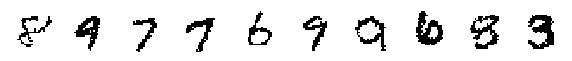

In [79]:
print("True image")
display_imgs(img)

In [80]:
re_encoded_img_dist = vae(img)

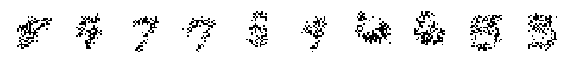

In [87]:
display_imgs(re_encoded_img_dist.sample())

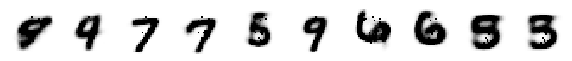

In [88]:
display_imgs(re_encoded_img_dist.mean())

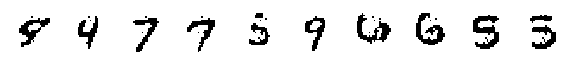

In [89]:
display_imgs(re_encoded_img_dist.mode())

In [90]:
# Generate new samples
z = prior.sample(10)

In [91]:
x_tilde = decoder(z)

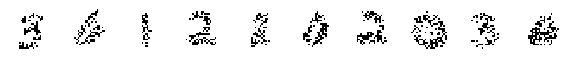

In [92]:
display_imgs(x_tilde.sample())

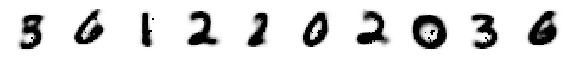

In [93]:
display_imgs(x_tilde.mean())

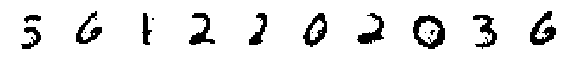

In [94]:
display_imgs(x_tilde.mode())